In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from random import seed, shuffle
import os
from pathlib import Path
import glob
from datetime import datetime

import librosa

from pyannote.audio import Pipeline
from pyannote.core import json

from matplotlib import pyplot as plt, lines
import seaborn as sns

from sklearn.manifold import TSNE
import umap
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler

from scipy import stats
from scipy.stats import ks_2samp
from scipy.spatial.distance import directed_hausdorff, euclidean, cosine, pdist

from src import (
    downsample as downsamp_audio, 
    embedding_extractor as ee, 
    dimension_reducer as dr, 
    distance_metrics as dm, 
    downsample as ds,
    emb_manipulator as em
)

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [20]:
def load_embeddings(emb_dir, files, participants_to_exclude=None):
    
    #directory where the embeddings are all stored
    
    #files is always a list. points to all the .csv of embeddings to load
    #if we have just one .csv, make sure files is a list with one name
    
    #participants_to_exclude is participants to remove from the df
    
    emb_unscaled = pd.DataFrame()

    for f in files:
        temp = pd.read_csv(os.path.join(emb_dir,f), index_col=0)
        temp['data_set'] = [Path(f).stem]*temp.shape[0]
        emb_unscaled = pd.concat([emb_unscaled,temp], ignore_index=True)

    #emb_down_unscaled = em.resample_data(emb,1)

    scaler = StandardScaler()
    emb = pd.DataFrame(scaler.fit_transform(emb_unscaled.drop(columns=['part_id','data_set'])))
    #emb['part_id'] = emb_unscaled.part_id.astype('string').to_numpy()
    #emb['data_set'] = emb_unscaled.data_set.astype('string').to_numpy()

    pid = []
    sex_list = []
    for name,corpus in zip(emb_unscaled.part_id, emb_unscaled.data_set):
        name = str(name)
        if corpus == 'spont_script_all_0606':
            pid.append(name.split("_")[0].zfill(3))# + "_" + name.split("_")[3])
            sex_list.append(name.split("_")[1])
        else:
            pid.append(name.split("_")[0].zfill(3))
            sex_list.append('F')

    emb['part_id'] = pid
    emb['sex'] = sex_list
    emb['data_set'] = emb_unscaled.data_set.astype('string').to_numpy()

    labels = ['part_id', 'data_set','sex']
    
    emb = emb[~emb.part_id.isin(part_to_exclude)]
    return emb

In [30]:
emb_dir = '/Users/rahulbrito/Documents/projects/infantvoice/data/embeddings'
#original_files = ['IV_001-020_0316.csv','IV_021-023-BB003_0601.csv','spont_script_all_0606.csv', '2022_06_24_BB042_BB002_BB007.csv','2022_08_03_12BBs.csv']
#noise_reduced_files = ['spont_script_all_0606.csv','2022_08_09_noise_reduced.csv']

original_files = ['IV_001-020_0316.csv','IV_021-023-BB003_0601.csv', '2022_06_24_BB042_BB002_BB007.csv','2022_08_03_12BBs.csv']
noise_reduced_files = ['2022_08_09_noise_reduced.csv']

participants_to_exclude = ['001', '002','003', '004','005', '006','007', '008','009', '010']

emb_nr = load_embeddings(emb_dir, noise_reduced_files,participants_to_exclude)
emb_original = load_embeddings(emb_dir,original_files,participants_to_exclude)

In [31]:
emb_nr.part_id.unique().shape, emb_original.part_id.unique().shape

((28,), (28,))

In [32]:
emb_nr.shape, emb_original.shape

((881, 515), (1001, 515))

In [33]:
distance_nr = dm.hausdorff_distances(emb_nr.drop(columns=['data_set', 'sex']))
distance_original = dm.hausdorff_distances(emb_original.drop(columns=['data_set', 'sex']))

Processing row 27, col 27


In [26]:
distance_nr

,011,012,013,014,015,016,017,018,019,020,...,BB012,BB013,BB014,BB016,BB019,BB020,BB021,BB022,BB038,BB042
011,0.000000,26.649309,25.906895,25.516782,24.652265,24.881302,24.807470,25.505131,26.547226,25.047160,...,24.706308,28.986509,25.816342,25.461091,26.788908,27.859518,27.081151,28.660478,27.544688,28.102096
012,24.353322,0.000000,23.963025,24.182164,25.211244,24.161528,24.435515,24.127256,25.313796,23.826375,...,24.247856,29.023394,25.770638,25.090489,25.873878,26.907406,26.256497,30.435291,27.739911,27.598240
013,26.164117,28.177670,0.000000,24.837430,25.664985,26.349669,24.614820,25.151782,26.261338,24.771253,...,26.016461,27.807513,26.178388,25.825542,27.848523,27.966015,27.265614,29.063388,29.938558,27.734619
014,25.120449,26.901681,25.432821,0.000000,24.770757,25.126409,24.630978,24.949529,26.981649,24.214317,...,25.424710,27.732603,26.255818,25.996205,25.817599,26.363100,26.336638,27.616276,27.290566,29.005405
015,22.934980,25.420263,23.299737,22.682054,0.000000,23.749764,22.855457,22.261877,24.559705,22.305245,...,24.035086,27.228250,23.417262,23.655936,24.739947,25.599185,24.471795,28.134238,26.550080,27.467965
016,24.781706,26.056376,25.203655,24.281176,25.432805,0.000000,24.105720,23.769123,25.868439,24.015438,...,24.573544,28.283552,25.701066,25.679174,25.875930,25.993176,26.579329,27.982510,27.970791,27.751796
017,28.531183,31.468991,27.588638,26.902523,30.009858,28.101431,0.000000,27.725589,29.948420,25.808336,...,28.441648,31.591849,29.107402,26.265287,29.257487,31.289363,31.612924,32.563327,32.438879,32.157606
018,24.320755,25.866354,24.312064,25.124533,23.933370,23.788489,24.080450,0.000000,25.720342,23.984196,...,24.937706,28.532549,25.384337,24.451460,25.937413,26.419255,24.566992,29.771647,28.249390,27.555783
019,31.720177,33.735838,30.409520,30.353049,31.992961,30.317605,30.057009,31.246366,0.000000,31.012593,...,31.930265,31.247731,31.890688,31.694421,32.232672,33.875994,33.678929,35.438679,33.430963,34.188311
020,26.221285,26.713084,25.538296,25.060099,25.209023,26.108852,25.080470,24.893481,26.932861,0.000000,...,25.890843,27.313553,26.560439,26.039302,26.940261,28.661144,27.729117,30.112406,27.384341,27.416368


In [27]:
distance_original

,011,012,013,014,015,016,017,018,019,020,...,BB012,BB013,BB014,BB016,BB019,BB020,BB021,BB022,BB038,BB042
011,0.000000,26.788627,28.533352,29.818328,27.283694,26.758111,28.282193,27.693461,31.067036,27.660865,...,28.231883,32.184519,28.513797,29.813750,28.603477,29.112889,29.792322,30.290474,29.572259,30.643308
012,30.247727,0.000000,30.916388,34.147879,30.758614,30.589316,28.956583,31.033257,34.192656,29.675775,...,30.527993,33.311880,32.569829,31.838800,32.486779,33.130750,30.965424,34.506379,32.041820,32.879171
013,27.066224,29.753861,0.000000,29.667930,28.666849,29.008878,26.963172,29.025457,31.023612,27.879067,...,28.413208,29.424027,29.196960,29.376886,30.053208,28.974480,28.890015,29.407053,30.890908,30.145580
014,28.160216,30.033891,28.679064,0.000000,27.517271,26.095902,29.015272,28.798602,32.442575,27.116470,...,29.172196,31.092124,28.559973,29.628445,27.432628,27.892169,30.544676,29.878463,30.554208,30.684987
015,25.828483,28.405547,29.243574,27.336737,0.000000,26.536514,28.190124,27.077659,31.218407,27.429027,...,27.274801,29.841695,26.642041,28.642836,27.033867,27.236830,27.789182,29.604693,28.620859,29.072084
016,25.119844,26.435108,27.408042,27.039097,25.808503,0.000000,27.951617,27.127673,30.464612,27.401946,...,27.333591,31.460642,26.482044,27.566018,28.223933,26.798316,28.365022,28.972031,31.064573,29.065205
017,27.808479,29.579914,26.127399,30.790664,28.295626,30.516293,0.000000,30.421152,31.125242,26.549725,...,28.207420,28.662363,30.019709,28.024096,30.588850,30.041640,29.658490,30.840986,28.851315,28.543045
018,26.420395,29.338722,29.473374,31.429029,27.948032,28.541512,29.112008,0.000000,31.074260,29.610933,...,29.308022,29.478128,29.721940,29.888352,29.913466,28.843533,29.471048,30.893891,29.878568,30.332118
019,30.517344,33.886381,34.034250,35.399436,33.569983,33.296693,32.034042,33.197834,0.000000,33.579879,...,31.783637,32.907230,33.076263,33.078862,32.878317,32.497289,33.882335,35.140395,33.614247,32.442437
020,26.637340,26.905337,27.650987,29.308501,28.629752,28.825834,26.093855,29.121211,31.590326,0.000000,...,28.046295,28.813754,30.157413,28.610572,29.702659,29.268822,28.779244,30.427848,28.252777,30.149150


Text(0, 0.5, 'Euclidean distance')

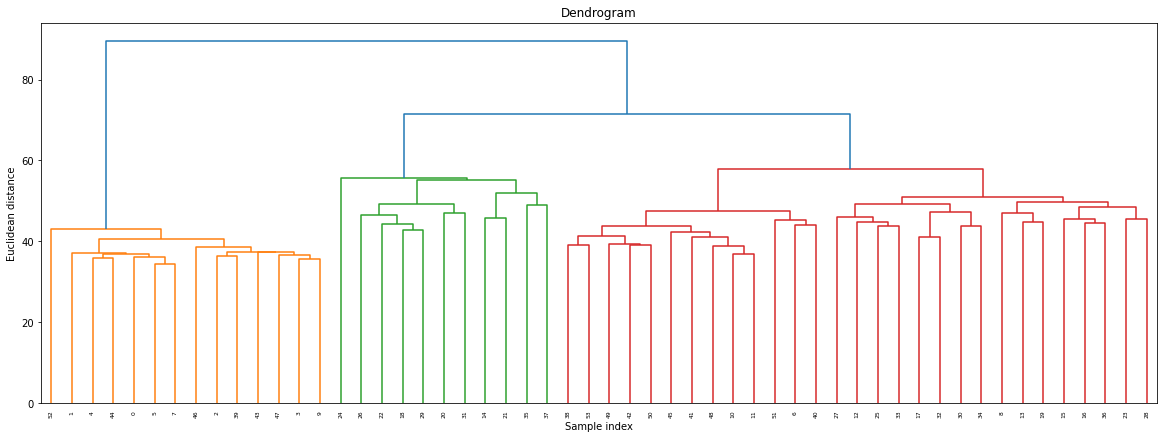

In [13]:
import scipy.cluster.hierarchy as sc

# Plot dendrogram
plt.figure(figsize=(20, 7))  
plt.title("Dendrograms")  

# Create dendrogram
sc.dendrogram(sc.linkage(distance, method='complete'))

plt.title('Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Euclidean distance')

In [15]:
[np.where(distance.index == i) for i in distance['BB005'].nlargest(20).index]

[(array([24]),),
 (array([14]),),
 (array([35]),),
 (array([18]),),
 (array([28]),),
 (array([37]),),
 (array([31]),),
 (array([29]),),
 (array([19]),),
 (array([23]),),
 (array([21]),),
 (array([1]),),
 (array([33]),),
 (array([27]),),
 (array([34]),),
 (array([15]),),
 (array([13]),),
 (array([8]),),
 (array([36]),),
 (array([16]),)]

In [14]:
farthest_voice = distance['BB006'].nlargest(34).index
farthest_voice

Index(['069', '133', '051', '131', '064', '058', '066', '056', '062', '059',
       '132', '057', '065', '019', '017', '050', '061', '053', '060', '067',
       '071', '070', '052', '068', '055', '072', '063', '049', 'BB022',
       'BB007', 'BB042', 'BB016', '022', 'BB020'],
      dtype='object')

In [36]:
closest_voice = distance['BB005'].nsmallest(12).index
closest_voice

Index(['BB005', 'BB014', 'BB038', 'BB002', 'BB016', 'BB012', 'BB020', 'BB006',
       '016', '015', 'BB042', 'BB003'],
      dtype='object')

In [148]:
part_1_20 = r'/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/0300222_recordings_16khz'
part_21_23_BB03 = r'/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/053122_new_participants/audio_16kHz'
BB12s = r'
spont_script = "/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/gasser_readings/preprocessed_audios_dur3sec"

part_1_20_rec = glob.glob(part_1_20 + '/*',  recursive=True)
part_21_23_BB03_rec = glob.glob(part_21_23_BB03 + '/*',  recursive=True)

script_rec = glob.glob(spont_script+'/*/*', recursive=True)
script_rec = [file for file in script_rec if 'script' in file]


wav_files = part_1_20_rec + part_21_23_BB03_rec + script_rec
#wav_files = part_1_20_rec + part_21_23_BB03_rec #+ script_rec

wav_data = {Path(wav).stem.split("_")[0]:librosa.load(wav, sr=16000, mono=True) for wav in wav_files}
wav_data.keys(), len(wav_data.keys())

(dict_keys(['014', '001', '015', '003', '017', '016', '002', '006', '012', '013', '007', '011', '005', '004', '010', '009', '020', '008', '018', '019', 'BB003', '021', '022', '132', '133', '070', '071', '049', '065', '062', '053', '052', '055', '063', '064', '131', '072', '061', '066', '059', '050', '057', '068', '056', '069', '051', '067', '058', '060']),
 49)

In [149]:
## shape/(framelength/4) + 1 = num_embed
## num_embed-1 = shape/(framelength/4)
## 1/(num_embed-1) = (framelength/4)/shape
## shape/(num_embed-1) = framelength/4
## 4 * shape/(num_embed-1) = framelength
#frame_length = 4*l//(emb.shape[0]-1)

f0 = {part:librosa.yin(wav[0], 
                  sr=16000,
                  fmin = librosa.note_to_hz('C2'), 
                  fmax= librosa.note_to_hz('C7')) 
      for part,wav in wav_data.items()}

In [150]:
f_lower_lim_humans=50
f_upper_lim_humans=500
f0_filtered = {part:[f for f in f_series if f>f_lower_lim_humans if f<f_upper_lim_humans] for part, f_series in f0.items()}

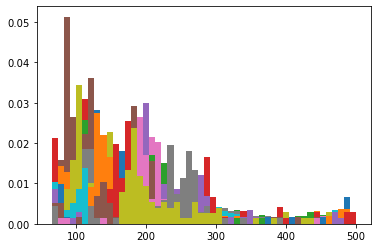

In [151]:
norm_f0 = {}

bins = 50
for part,f in f0_filtered.items():
    n,bins, patches = plt.hist(f, density=True, bins=bins)
    norm_f0[part] = n

In [152]:
target = 'BB003'
ks_test = {part:ks_2samp(norm_f0[target], f_n)
 for part, f_n in norm_f0.items()}

In [153]:
[(v,ks_test[v]) for v in farthest_voice]

[('062', KstestResult(statistic=0.74, pvalue=1.409544601041165e-13)),
 ('069', KstestResult(statistic=0.66, pvalue=1.3182765881237494e-10)),
 ('133', KstestResult(statistic=0.62, pvalue=2.623447502564397e-09)),
 ('131', KstestResult(statistic=0.76, pvalue=2.08228179699263e-14)),
 ('058', KstestResult(statistic=0.54, pvalue=4.929118631187453e-07)),
 ('051', KstestResult(statistic=0.6, pvalue=1.0624962385385807e-08)),
 ('067', KstestResult(statistic=0.74, pvalue=1.409544601041165e-13)),
 ('056', KstestResult(statistic=0.56, pvalue=1.4534580579142488e-07)),
 ('059', KstestResult(statistic=0.6, pvalue=1.0624962385385807e-08)),
 ('066', KstestResult(statistic=0.7, pvalue=5.022006049995235e-12)),
 ('057', KstestResult(statistic=0.74, pvalue=1.409544601041165e-13)),
 ('019', KstestResult(statistic=0.2, pvalue=0.2719135601522248)),
 ('060', KstestResult(statistic=0.58, pvalue=4.047604718242212e-08)),
 ('049', KstestResult(statistic=0.64, pvalue=6.078719823015066e-10)),
 ('052', KstestResult(st

In [154]:
[(v,ks_test[v]) for v in closest_voice]

[('BB003', KstestResult(statistic=0.0, pvalue=1.0)),
 ('005', KstestResult(statistic=0.42, pvalue=0.0002460240344273171)),
 ('001', KstestResult(statistic=0.46, pvalue=3.800827929128319e-05)),
 ('004', KstestResult(statistic=0.46, pvalue=3.800827929128319e-05)),
 ('009', KstestResult(statistic=0.32, pvalue=0.011511738725894704)),
 ('015', KstestResult(statistic=0.5, pvalue=4.8075337049514946e-06)),
 ('016', KstestResult(statistic=0.3, pvalue=0.02170784069014051))]

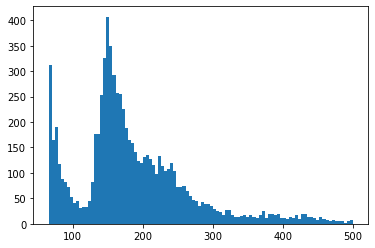

In [82]:
plt.hist(f0_filtered['BB003'], density=True, bins=bins)

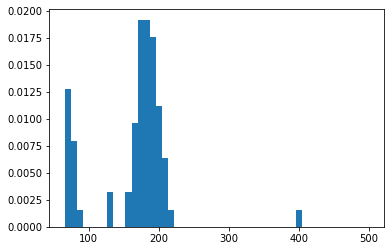

In [114]:
plt.hist(f0_filtered['062'], density=True, bins=bins)
plt.show()

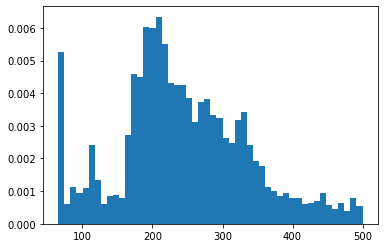

In [115]:
plt.hist(f0_filtered['005'], density=True, bins=bins)
plt.show()

In [52]:
f0_median = {part:np.median(f) for part,f in f0.items()}

for wav in wav_files:
    temp = emb[emb.part_id==Path(wav).stem]
    emb.loc[emb.part_id==Path(wav).stem.split("_")[0], 'f0'] = f0_median[Path(wav).stem.split("_")[0]]

In [19]:
X = emb.drop(columns=labels)

#metric = 'cosine'
metric= 'euclidean'

tsne = TSNE(n_components=2, perplexity=60, init = 'pca', random_state=20, metric=metric)
umap = umap.UMAP(n_components=2,metric=metric)

Xtsne = tsne.fit_transform(X)
Xumap = umap.fit_transform(X)

[Text(0.5, 1.0, 'tsneeuclidean')]

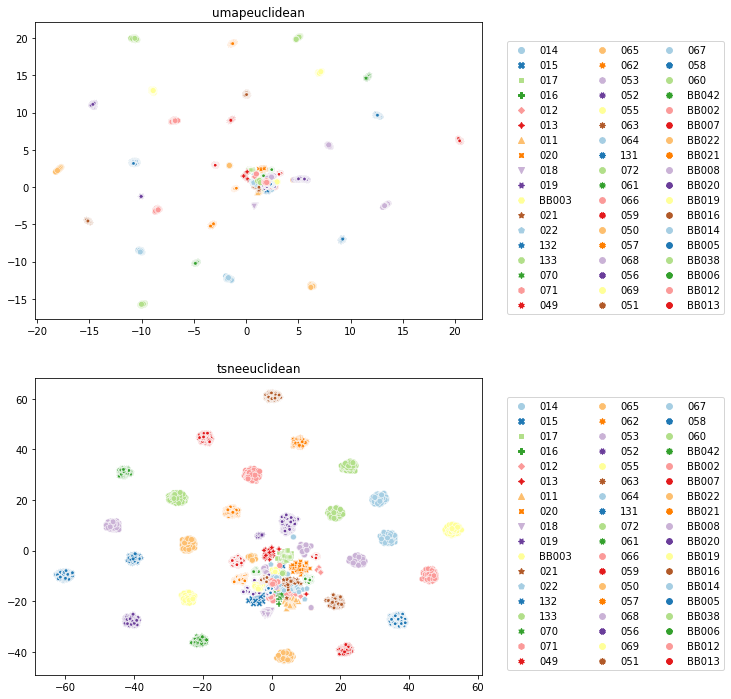

In [20]:
##plot 2 dimensions from each dimension reduction
fig, (ax1,ax2) = plt.subplots(2,figsize=(8,12))

clust_plt_umap = sns.scatterplot(x=Xumap[:,0], y=Xumap[:,1], ax=ax1, palette="Paired", hue=emb.part_id, style=emb.part_id, legend=True)
ax1.legend(loc="lower center",bbox_to_anchor=(1.3,  0), ncol=3)
clust_plt_umap.set(title = 'umap' + metric)

clust_plt_tsne = sns.scatterplot(x=Xtsne[:,0], y=Xtsne[:,1], ax=ax2, palette="Paired", hue=emb.part_id, style=emb.part_id,legend=True)
ax2.legend(loc="lower center",bbox_to_anchor=(1.3,  0), ncol=3)
clust_plt_tsne.set(title = 'tsne' + metric)

[Text(0.5, 1.0, 'tsneeuclidean')]

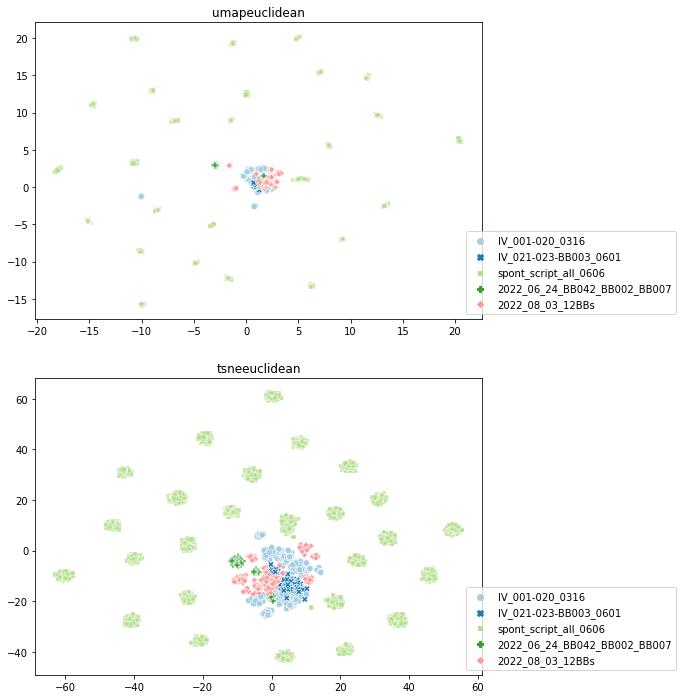

In [21]:
##plot 2 dimensions from each dimension reduction
fig, (ax1,ax2) = plt.subplots(2,figsize=(8,12))

clust_plt_umap = sns.scatterplot(x=Xumap[:,0], y=Xumap[:,1], ax=ax1, palette="Paired", hue=emb.data_set, style=emb.data_set, legend=True)
ax1.legend(loc="lower center",bbox_to_anchor=(1.2,  0), ncol=1)
clust_plt_umap.set(title = 'umap' + metric)

clust_plt_tsne = sns.scatterplot(x=Xtsne[:,0], y=Xtsne[:,1], ax=ax2, palette="Paired", hue=emb.data_set, style=emb.data_set,legend=True)
ax2.legend(loc="lower center",bbox_to_anchor=(1.2,  0), ncol=1)
clust_plt_tsne.set(title = 'tsne' + metric)

[Text(0.5, 1.0, 'tsneeuclidean')]

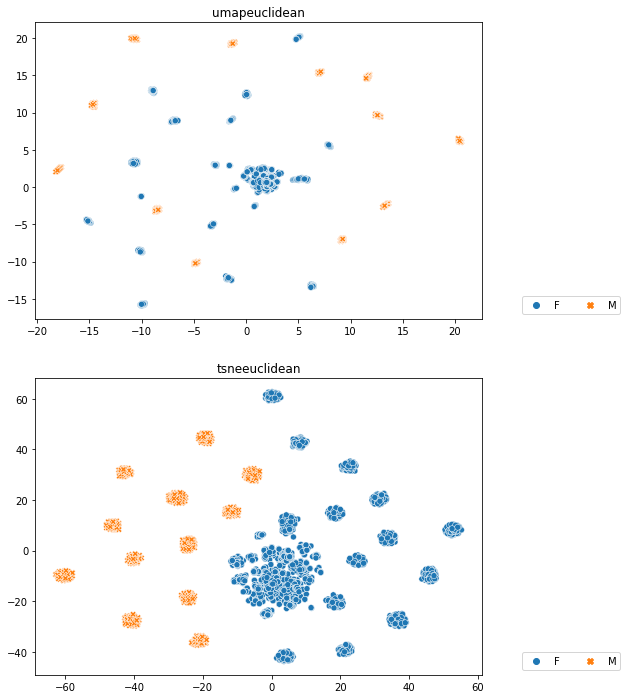

In [22]:
##plot 2 dimensions from each dimension reduction
fig, (ax1,ax2) = plt.subplots(2,figsize=(8,12))

clust_plt_umap = sns.scatterplot(x=Xumap[:,0], y=Xumap[:,1], ax=ax1, hue=emb.sex, style=emb.sex, legend=True)
ax1.legend(loc="lower center",bbox_to_anchor=(1.2,  0), ncol=2)
clust_plt_umap.set(title = 'umap' + metric)

clust_plt_tsne = sns.scatterplot(x=Xtsne[:,0], y=Xtsne[:,1], ax=ax2, hue=emb.sex, style=emb.sex,legend=True)
ax2.legend(loc="lower center",bbox_to_anchor=(1.2,  0), ncol=2)
clust_plt_tsne.set(title = 'tsne' + metric)

In [36]:
Xumap_df = pd.DataFrame(Xumap, columns=['dim0', 'dim1'])
Xumap_df['part_id'] = emb.part_id.to_numpy()
Xtsne_df = pd.DataFrame(Xtsne, columns=['dim0', 'dim1'])
Xtsne_df['part_id'] = emb.part_id.to_numpy()

d_umap = dm.hausdorff_distances(Xumap_df)
d_tsne = dm.hausdorff_distances(Xtsne_df)

Processing row 48, col 48


In [38]:
target = 'BB003'
d_umap[target].abs().nlargest(n=6)

059    24.503519
067    23.216715
065    21.552784
055    20.327050
061    19.162675
064    18.868959
Name: BB003, dtype: float64

In [37]:
d_tsne[target].abs().nlargest(n=6)

061    86.377619
051    78.632961
059    73.215142
052    68.427907
131    66.150753
066    64.752962
Name: BB003, dtype: float64

In [39]:
d_umap_flat = pd.DataFrame(d_umap.to_numpy().flatten()).dropna()
d_tsne_flat = pd.DataFrame(d_tsne.to_numpy().flatten()).dropna()

d_umap_flat.corrwith(d_tsne_flat)

0    0.562002
dtype: float64

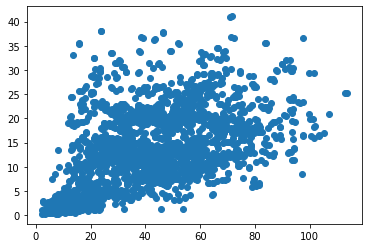

In [40]:
plt.scatter(d_tsne_flat,d_umap_flat)

In [47]:
knn=50
knn_classes=10
subsetsize=1000

#we are always comparing to emb_down as our high-dimension embedding. 
high_dim = X.to_numpy()
classes= emb.part_id.to_numpy() #extract the categories/labels

#compare tsne to embeddings
low_dim = Xtsne
dist_tsne = dm.embedding_quality(high_dim, low_dim, classes, knn=knn, knn_classes=knn_classes, subsetsize=subsetsize)

#compare umap to embeddings
low_dim = Xumap
dist_umap = dm.embedding_quality(high_dim, low_dim, classes, knn=knn, knn_classes=knn_classes, subsetsize=subsetsize)


#create a dataframe of all distance metrics for each dimension method
dist = pd.DataFrame(np.vstack((dist_tsne, dist_umap)), columns = ['micro', 'meso', 'macro'], index = ['tsne', 'umap'])
#dist = pd.DataFrame(dist_tsne, dist_umap, index = ['micro', 'meso', 'macro'], columns= ['tsne','umap'])
dist = dist.round(decimals=3)

In [48]:
dist

,micro,meso,macro
tsne,0.625,0.514,0.441
umap,0.548,0.412,0.324


[Text(0.5, 1.0, 'tsneeuclidean')]

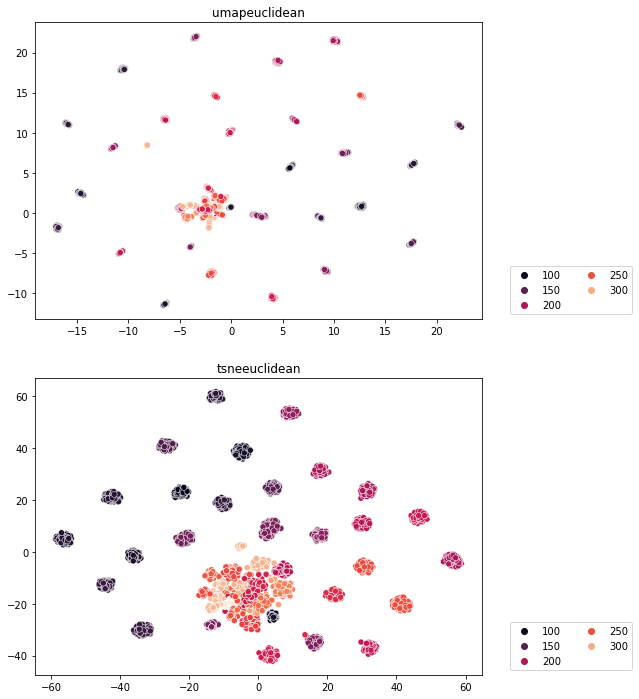

In [53]:
##plot 2 dimensions from each dimension reduction
fig, (ax1,ax2) = plt.subplots(2,figsize=(8,12))

clust_plt_umap = sns.scatterplot(x=Xumap[:,0], y=Xumap[:,1], ax=ax1, palette="rocket",hue=emb.f0, legend=True)
ax1.legend(loc="lower center",bbox_to_anchor=(1.2,  0), ncol=2)
clust_plt_umap.set(title = 'umap' + metric)

clust_plt_tsne = sns.scatterplot(x=Xtsne[:,0], y=Xtsne[:,1], ax=ax2, palette="rocket", hue=emb.f0, legend=True)
ax2.legend(loc="lower center",bbox_to_anchor=(1.2,  0), ncol=2)
clust_plt_tsne.set(title = 'tsne' + metric)

In [139]:
gemap_file = os.path.join(emb_dir,'060722_segmented_23moms_scripted_3sec.csv')

gemap_unscaled = pd.read_csv(gemap_file, index_col=0)
gemap_unscaled = gemap_unscaled.drop(columns=['start','end'])

scaler = StandardScaler()
gemap = pd.DataFrame(scaler.fit_transform(gemap_unscaled.drop(columns='part_id')), columns=gemap_unscaled.columns[:-1])
gemap['part_id'] = [part.zfill(3) for part in gemap_unscaled.part_id.to_numpy()]


In [142]:
corpus = []
sex_list = []
for name in gemap_unscaled.index:
    name = str(name)
    name = Path(name).stem
    if 'script' in name:
        corpus.append('spont_script')
        sex_list.append(name.split("_")[1])
    else:
        corpus.append("IV")# + "_" + name.split("_")[3])
        sex_list.append("F")

gemap['data_set'] = corpus
gemap['sex'] = sex_list

In [81]:
Y = gemap.drop(columns=labels)

metric = 'euclidean'

tsne = TSNE(n_components=2, perplexity=60, init = 'pca', random_state=20, metric=metric)
umap = umap.UMAP(n_components=2,metric=metric)

Ytsne = tsne.fit_transform(Y)
Yumap = umap.fit_transform(Y)


In [183]:
Ytsne_df = pd.DataFrame(Ytsne, columns=['dim0','dim1'])
Ytsne_df['part_id'] = gemap.part_id
Ytsne_df['data_set'] = gemap.data_set
Ytsne_IV = Ytsne_df[Ytsne_df.data_set == 'IV']

[Text(0.5, 1.0, 'tsneeuclidean gemaps of LEFT SIDE of infantvoice data')]

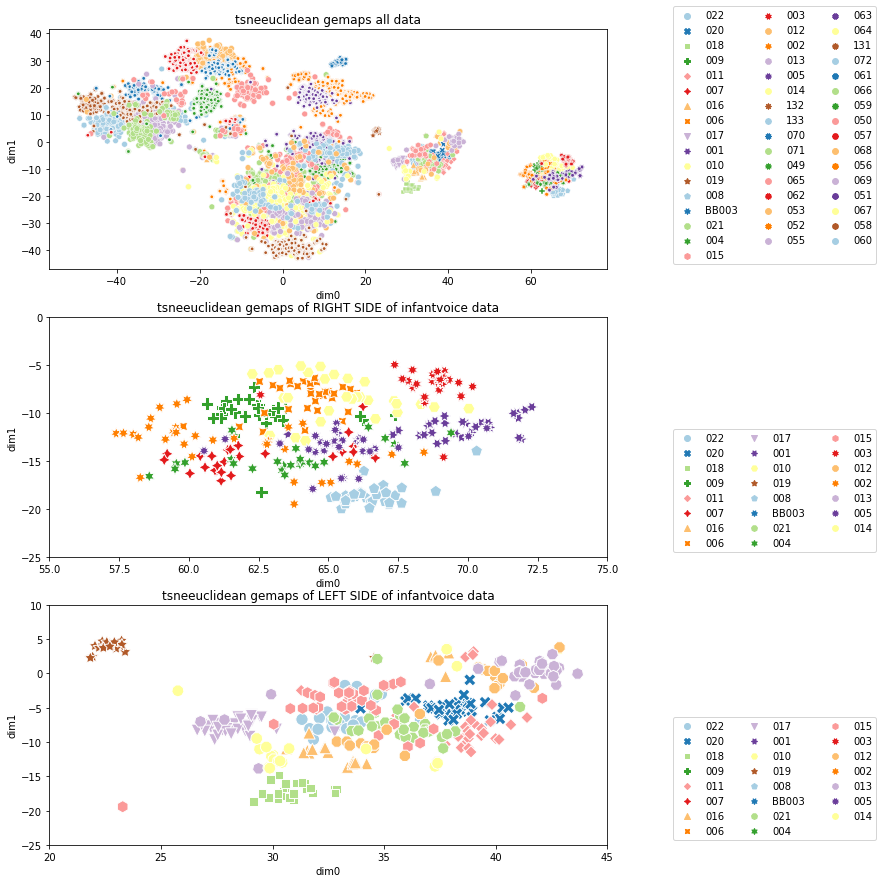

In [208]:
##plot 2 dimensions from each dimension reduction
fig, (ax1,ax2,ax3) = plt.subplots(3,figsize=(10,15))

clust_plt_tsne = sns.scatterplot(x=Ytsne_df.dim0, y=Ytsne_df.dim1, ax=ax1, palette="Paired", hue=Ytsne_df.part_id, style=Ytsne_df.part_id, legend=True)
ax1.legend(loc="lower center",bbox_to_anchor=(1.3,  0), ncol=3)
clust_plt_tsne.set(title = 'tsne' + metric +" gemaps all data")

clust_plt_umap = sns.scatterplot(x=Ytsne_IV.dim0, y=Ytsne_IV.dim1, ax=ax2, palette="Paired",hue=Ytsne_IV.part_id, style=Ytsne_IV.part_id, legend=True, s=150)
ax2.legend(loc="lower center",bbox_to_anchor=(1.3,  0), ncol=3)
ax2.set_xlim([55,75])
ax2.set_ylim([-25,0])
clust_plt_umap.set(title = 'tsne' + metric +" gemaps of RIGHT SIDE of infantvoice data")

clust_plt_umap = sns.scatterplot(x=Ytsne_IV.dim0, y=Ytsne_IV.dim1, ax=ax3, palette="Paired",hue=Ytsne_IV.part_id, style=Ytsne_IV.part_id, legend=True, s=150)
ax3.legend(loc="lower center",bbox_to_anchor=(1.3,  0), ncol=3)
ax3.set_xlim([20,45])
ax3.set_ylim([-25,10])
clust_plt_umap.set(title = 'tsne' + metric +" gemaps of LEFT SIDE of infantvoice data")


[Text(0.5, 1.0, 'tsneeuclidean')]

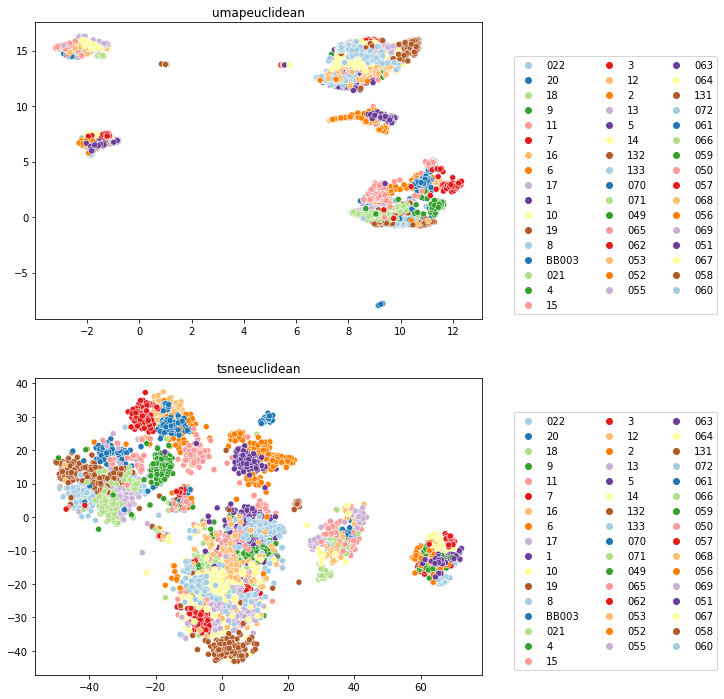

In [84]:
##plot 2 dimensions from each dimension reduction
fig, (ax1,ax2) = plt.subplots(2,figsize=(8,12))

clust_plt_umap = sns.scatterplot(x=Yumap[:,0], y=Yumap[:,1], ax=ax1, palette="Paired",hue=gemap.part_id, legend=True)
ax1.legend(loc="lower center",bbox_to_anchor=(1.3,  0), ncol=3)
clust_plt_umap.set(title = 'umap' + metric)

clust_plt_tsne = sns.scatterplot(x=Ytsne[:,0], y=Ytsne[:,1], ax=ax2, palette="Paired", hue=gemap.part_id, legend=True)
ax2.legend(loc="lower center",bbox_to_anchor=(1.3,  0), ncol=3)
clust_plt_tsne.set(title = 'tsne' + metric)

[Text(0.5, 1.0, 'tsneeuclidean')]

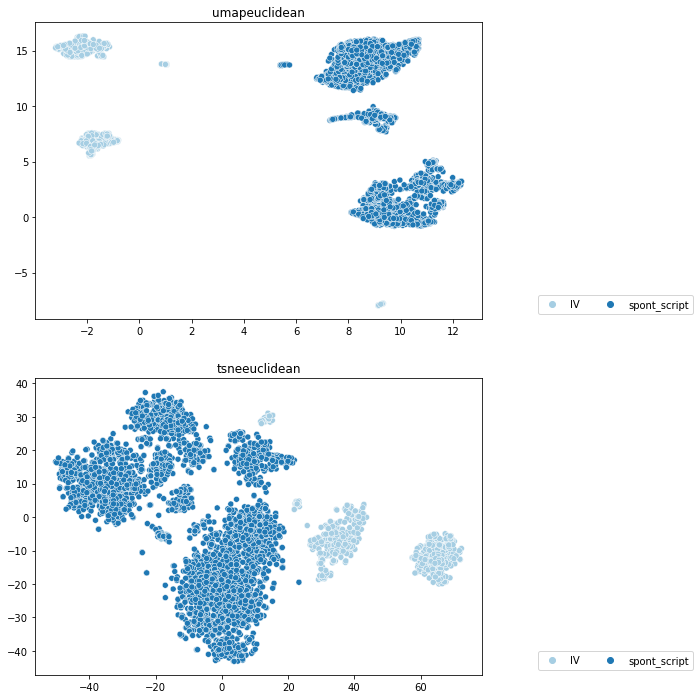

In [95]:
##plot 2 dimensions from each dimension reduction
fig, (ax1,ax2) = plt.subplots(2,figsize=(8,12))

clust_plt_umap = sns.scatterplot(x=Yumap[:,0], y=Yumap[:,1], ax=ax1, palette="Paired",hue=gemap.data_set, legend=True)
ax1.legend(loc="lower center",bbox_to_anchor=(1.3,  0), ncol=3)
clust_plt_umap.set(title = 'umap' + metric)

clust_plt_tsne = sns.scatterplot(x=Ytsne[:,0], y=Ytsne[:,1], ax=ax2, palette="Paired", hue=gemap.data_set, legend=True)
ax2.legend(loc="lower center",bbox_to_anchor=(1.3,  0), ncol=3)
clust_plt_tsne.set(title = 'tsne' + metric)

[Text(0.5, 1.0, 'tsneeuclidean')]

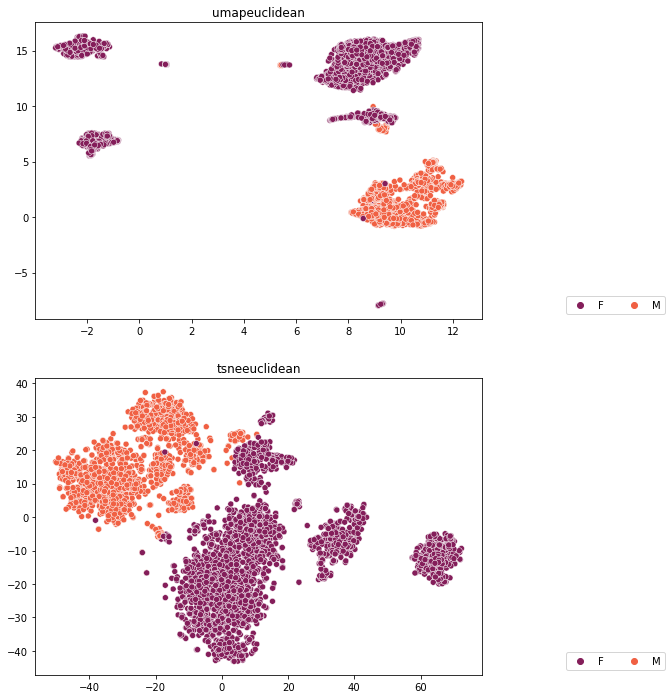

In [98]:
##plot 2 dimensions from each dimension reduction
fig, (ax1,ax2) = plt.subplots(2,figsize=(8,12))

clust_plt_umap = sns.scatterplot(x=Yumap[:,0], y=Yumap[:,1], ax=ax1, palette="rocket",hue=gemap.sex, legend=True)
ax1.legend(loc="lower center",bbox_to_anchor=(1.3,  0), ncol=3)
clust_plt_umap.set(title = 'umap' + metric)

clust_plt_tsne = sns.scatterplot(x=Ytsne[:,0], y=Ytsne[:,1], ax=ax2, palette="rocket", hue=gemap.sex, legend=True)
ax2.legend(loc="lower center",bbox_to_anchor=(1.3,  0), ncol=3)
clust_plt_tsne.set(title = 'tsne' + metric)

In [106]:
#PCA for comparison
pca_pyannote = PCA(n_components=512).fit(X)
pca_gemaps = PCA(n_components=88).fit(Y)

Xpca = pca_pyannote.transform(X)
Ypca = pca_gemaps.transform(Y)

X_exp_var = pca_pyannote.explained_variance_ratio_
Y_exp_var = pca_gemaps.explained_variance_ratio_

<AxesSubplot:>

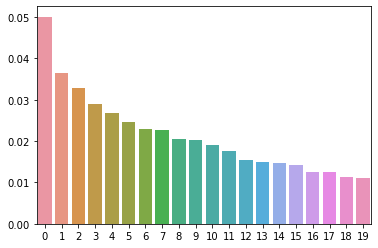

In [110]:
sns.barplot(x=np.arange(20),y=X_exp_var[0:20])

<AxesSubplot:>

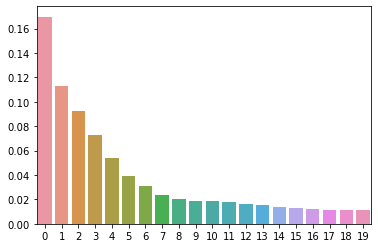

In [112]:
sns.barplot(x=np.arange(20),y=Y_exp_var[0:20])

In [143]:
X_part_count = emb.groupby('part_id').count().iloc[:,0].to_numpy()
Y_part_count = gemap.groupby('part_id').count().iloc[:,0].to_numpy()
index_len = np.minimum(Y_part_count,X_part_count)
samples_per_group_dict = dict(zip(gemap.groupby('part_id').count().index,index_len))

In [145]:
emb_reduced_samples = emb.groupby('part_id').apply(lambda group: group.sample(samples_per_group_dict[group.name])).reset_index(drop = True)
gemap_reduced_samples = gemap.groupby('part_id').apply(lambda group: group.sample(samples_per_group_dict[group.name])).reset_index(drop = True)

In [147]:
from sklearn.cross_decomposition import CCA

X_cc = emb_reduced_samples.drop(columns=labels)
Y_cc = gemap_reduced_samples.drop(columns=labels)

ca = CCA(n_components=88).fit(X_cc, Y_cc)

ValueError: invalid number of arguments

In [167]:
np.argpartition(np.abs(np.mean(ca.coef_, axis=0)), -4)[-4:]

array([36, 42, 33, 34])

In [168]:
np.abs(np.mean(ca.coef_, axis=0))

array([16.79587362, 16.58413589, 22.69505557, 18.64542914, 12.0041104 ,
       14.1761537 ,  5.55131244,  6.16152245,  6.44183749,  5.36706764,
        5.51634886,  1.05345744,  5.42689831,  4.55581317,  5.25803332,
        4.35164444,  2.16653062,  2.83363979,  0.42748419,  0.47636491,
        5.96636421,  3.76635654,  2.58099138,  1.93661737, 13.07908195,
        0.83951288,  5.45718449,  0.19847983,  3.18200359,  0.40256655,
       13.28795447,  7.93269475, 21.82652613, 23.81950446, 30.50257468,
       21.41901595, 23.40346391,  0.59990267, 14.85722163,  0.42203212,
       13.94648602,  7.38124058, 25.27531888, 10.36724136, 12.80819779,
        1.61585202,  7.9646522 ,  6.92337492, 10.41279675,  2.1225186 ,
       10.98115926, 10.95795906,  2.93426734, 10.8144889 , 12.37591651,
       11.65689878, 11.24322666, 15.42342035,  8.69949854,  2.45660466,
        7.56088952,  2.4470881 ,  7.19756043,  0.7393446 ,  6.06417633,
        0.87150828,  4.55350558,  8.37012503,  1.75504078,  2.31

<AxesSubplot:>

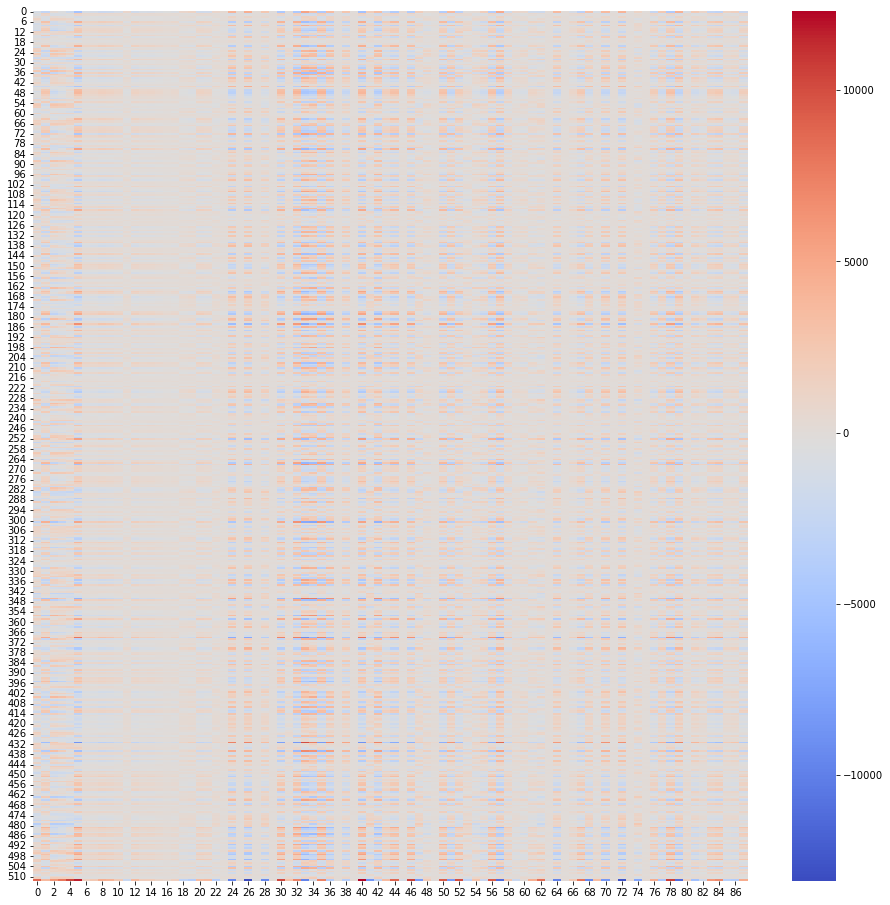

In [156]:
fig = plt.figure(figsize=(16,16))
sns.heatmap(ca.coef_, cmap="coolwarm")

